# Experiment: Determine Best Sampling Technique for the Telemarketing Dataset
By: Prajwal brijesh Ainapur

### AIM:
1. To determine the best sampling technique for the current model
2. To determine the effect of the duration column on model performance

In [1]:
#Importing Libraries
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, KMeansSMOTE, SVMSMOTE
from pycaret import classification, clustering
from pycaret.classification import *
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix,recall_score
from sklearn import metrics

import seaborn as sns
import pycaret
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/home/prajwal_brijesh_ainapur/upgradSubmissions/MS_PGM/bank-additional/bank-additional-full.csv')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
def trainPredict(tmp):

    _Xd, _y = tmp().fit_resample(X_train, y_train)
    print(y_train.shape)
    counter = Counter(_y)
    print(counter)
    
    df_tmp = pd.concat([_Xd, _y], axis = 1)
    classification_setup = classification.setup(data= df_tmp, target='y', fix_imbalance = False)
    lgbms = create_model('lightgbm', learning_rate = 0.3)
    print(counter)
    return lgbms, counter


def plotModel(tmp, tec):    
    lgbms_final = finalize_model(tmp)

    y_pred = predict_model(lgbms_final, data = X_test)

    cmat = confusion_matrix(y_test, y_pred.Label)
    print(cmat)
    trec = recall_score(y_test, y_pred.Label)
    print(trec)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred.Label)

    roc_auc = (metrics.auc(fpr, tpr))

    plt.title('Receiver Operating Characteristic' + str(tec))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

The first iteration of comparisons involve dropping the duration column as indicated by the dataset site followed by creating dummy variables

In [5]:
dfDrop = df.drop(columns = ['duration'], axis = 1)

In [6]:
X = dfDrop.drop(columns = ['y'], axis = 1)
y = dfDrop['y']
y.shape

(41188,)

In [7]:
counter = Counter(y)
print(counter)

Counter({'no': 36548, 'yes': 4640})


In [8]:
y = y.replace('no', 0)
y = y.replace('yes', 1)
counter = Counter(y)
print(counter)

Counter({0: 36548, 1: 4640})


In [9]:
Xd = pd.get_dummies(X, drop_first = True)
Xd.shape

(41188, 52)

Procedure for experiment:

1. 25% stratified split is made for test data 
2. Remaining 75% data is sampled and then used to train the model
3. Once the model is trained, the test data is used to test the performance of the model on unseen data

Iterations:

1. No Sampling
2. SMOTE
3. ADASYN
4. RandomOverSampler
5. KMeansSMOTE
6. SVMSMOTE
7. SMOTEENN
8. SMOTETomek

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xd, y, stratify=y, test_size=0.25)

In [11]:
X_test.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
  

In [12]:
counter = Counter(y_train)
print(counter)
counter = Counter(y_test)
print(counter)

Counter({0: 27411, 1: 3480})
Counter({0: 9137, 1: 1160})


In [13]:
print(X_train.shape)
print(X_test.shape)

(30891, 52)
(10297, 52)


In [14]:
#Training Logistic on actual dummy data

df_ori = pd.concat([X_train, y_train], axis = 1)
classification_setup = classification.setup(data= df_ori, target='y', fix_imbalance = False)

,Description,Value
0,session_id,8813
1,Target,y
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(30891, 53)"
5,Missing Values,False
6,Numeric Features,51
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
lgbms = create_model('lightgbm', learning_rate = 0.3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8988,0.8008,0.3184,0.6000,0.4160,0.3662,0.3884
1,0.8983,0.7858,0.3347,0.5899,0.4271,0.3759,0.3941
2,0.8918,0.7673,0.2653,0.5462,0.3571,0.3057,0.3296
3,0.8890,0.7825,0.2531,0.5210,0.3407,0.2879,0.3104
4,0.8969,0.7591,0.2939,0.5902,0.3924,0.3429,0.3679
5,0.8918,0.7817,0.2898,0.5420,0.3777,0.3243,0.3434
6,0.8969,0.7742,0.2816,0.5948,0.3823,0.3338,0.3617
7,0.8932,0.7633,0.2653,0.5603,0.3601,0.3098,0.3358
8,0.8996,0.7927,0.3115,0.6080,0.4119,0.3632,0.3876
9,0.8987,0.7777,0.3320,0.5912,0.4252,0.3744,0.3932


[[8908  229]
 [ 830  330]]
0.28448275862068967


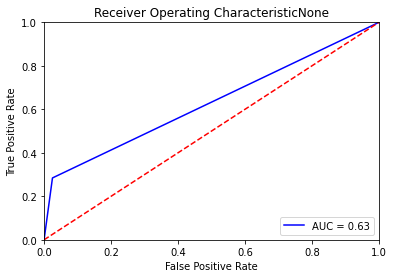

In [16]:
tec = None
plotModel(lgbms, tec)

In [17]:
tec = SMOTE
tmp, counter = trainPredict(tec)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9270,0.9726,0.9079,0.9442,0.9257,0.8541,0.8547
1,0.9263,0.9692,0.9079,0.9427,0.9250,0.8525,0.8531
2,0.9208,0.9672,0.8990,0.9401,0.9191,0.8416,0.8424
3,0.9247,0.9697,0.9079,0.9397,0.9235,0.8494,0.8499
4,0.9229,0.9692,0.8954,0.9477,0.9208,0.8458,0.8471
5,0.9226,0.9697,0.9079,0.9356,0.9215,0.8452,0.8456
6,0.9260,0.9708,0.9068,0.9432,0.9246,0.8520,0.8526
7,0.9249,0.9729,0.9037,0.9440,0.9234,0.8499,0.8507
8,0.9239,0.9675,0.9021,0.9434,0.9223,0.8478,0.8486
9,0.9252,0.9687,0.9073,0.9411,0.9239,0.8504,0.8510


Counter({1: 27411, 0: 27411})


[[8640  497]
 [ 705  455]]
0.3922413793103448


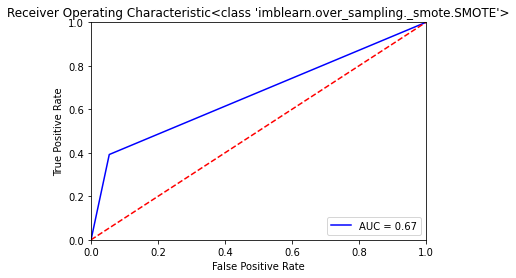

In [18]:
plotModel(tmp, tec)

In [19]:
tec = ADASYN
tmp, counter = trainPredict(tec)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9175,0.9643,0.8941,0.9365,0.9148,0.8349,0.8358
1,0.9212,0.9696,0.8995,0.9389,0.9188,0.8423,0.8430
2,0.9083,0.9625,0.8819,0.9294,0.9050,0.8165,0.8175
3,0.9214,0.9690,0.9047,0.9346,0.9194,0.8428,0.8432
4,0.9214,0.9691,0.9026,0.9365,0.9192,0.8428,0.8433
5,0.9127,0.9640,0.8946,0.9267,0.9104,0.8254,0.8259
6,0.9201,0.9696,0.9031,0.9334,0.9180,0.8402,0.8406
7,0.9177,0.9642,0.8962,0.9350,0.9152,0.8354,0.8361
8,0.9225,0.9684,0.9005,0.9405,0.9201,0.8449,0.8457
9,0.9204,0.9668,0.9079,0.9297,0.9187,0.8407,0.8409


Counter({0: 27411, 1: 26780})


[[8595  542]
 [ 707  453]]
0.3905172413793103


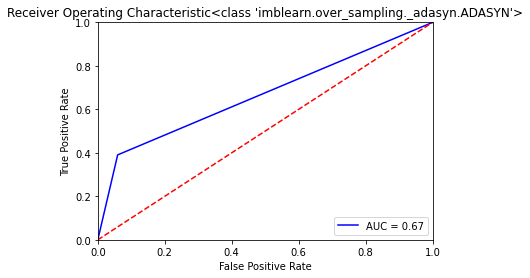

In [20]:
plotModel(tmp, tec)

In [21]:
tec = KMeansSMOTE
tmp, counter = trainPredict(tec)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9403,0.9737,0.9098,0.9689,0.9384,0.8807,0.8823
1,0.9416,0.9728,0.9160,0.9654,0.9400,0.8833,0.8844
2,0.9445,0.9715,0.9108,0.9765,0.9425,0.8890,0.8910
3,0.9429,0.9716,0.9087,0.9754,0.9409,0.8859,0.8879
4,0.9448,0.9733,0.9139,0.9739,0.9429,0.8895,0.8912
5,0.9447,0.9745,0.9128,0.9749,0.9429,0.8895,0.8913
6,0.9424,0.9741,0.9134,0.9695,0.9406,0.8848,0.8863
7,0.9421,0.9706,0.9118,0.9706,0.9403,0.8843,0.8859
8,0.9432,0.9722,0.9134,0.9711,0.9414,0.8864,0.8879
9,0.9369,0.9649,0.8978,0.9740,0.9343,0.8739,0.8765


Counter({1: 27411, 0: 27411})


[[8918  219]
 [ 847  313]]
0.26982758620689656


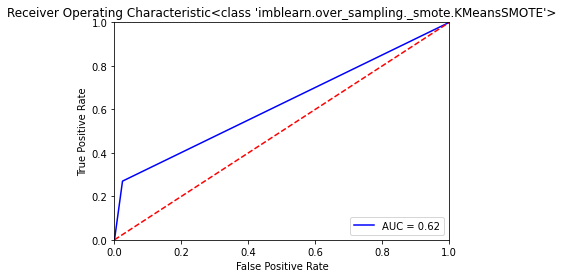

In [22]:
plotModel(tmp, tec)

In [23]:
tec = RandomOverSampler
tmp, counter = trainPredict(tec)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8239,0.9059,0.7826,0.8513,0.8155,0.6476,0.6497
1,0.8306,0.9167,0.7999,0.8507,0.8245,0.6612,0.6623
2,0.8392,0.9171,0.8135,0.8561,0.8343,0.6784,0.6792
3,0.8179,0.9042,0.7721,0.8481,0.8083,0.6356,0.6381
4,0.8220,0.9102,0.7805,0.8495,0.8135,0.6439,0.6460
5,0.8155,0.9050,0.7732,0.8429,0.8066,0.6308,0.6330
6,0.8197,0.9028,0.7758,0.8487,0.8106,0.6391,0.6415
7,0.8189,0.9103,0.7741,0.8484,0.8095,0.6376,0.6400
8,0.8348,0.9162,0.7914,0.8648,0.8265,0.6694,0.6718
9,0.8280,0.9069,0.7888,0.8541,0.8202,0.6558,0.6577


Counter({1: 27411, 0: 27411})


[[7969 1168]
 [ 493  667]]
0.575


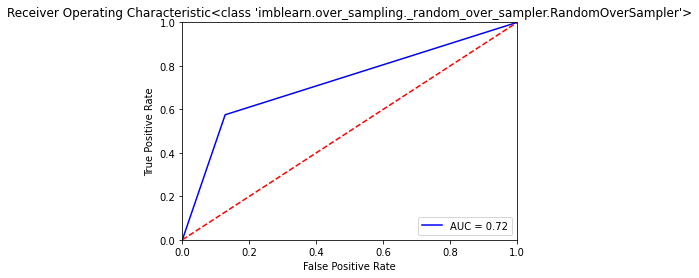

In [24]:
plotModel(tmp, tec)

In [25]:
tec = SVMSMOTE
tmp, counter = trainPredict(tec)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9317,0.9695,0.9104,0.9502,0.9299,0.8634,0.8642
1,0.9354,0.9712,0.9240,0.9448,0.9343,0.8707,0.8710
2,0.9229,0.9636,0.9026,0.9400,0.9209,0.8457,0.8464
3,0.9289,0.9671,0.9151,0.9403,0.9275,0.8577,0.8580
4,0.9247,0.9642,0.9036,0.9426,0.9227,0.8494,0.8501
5,0.9200,0.9637,0.9031,0.9339,0.9182,0.8399,0.8404
6,0.9242,0.9675,0.9047,0.9406,0.9223,0.8483,0.8489
7,0.9286,0.9698,0.9157,0.9393,0.9273,0.8572,0.8574
8,0.9218,0.9635,0.9036,0.9370,0.9200,0.8436,0.8441
9,0.9343,0.9711,0.9193,0.9471,0.9330,0.8686,0.8690


Counter({1: 27411, 0: 27411})


[[8624  513]
 [ 676  484]]
0.41724137931034483


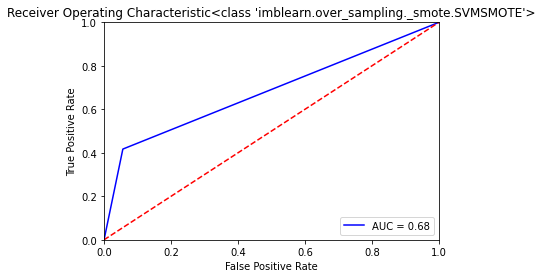

In [26]:
plotModel(tmp, tec)

In [27]:
from imblearn.combine import SMOTEENN, SMOTETomek

In [28]:
tec = SMOTEENN
tmp, counter = trainPredict(tec)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9504,0.9792,0.9461,0.9717,0.9587,0.8965,0.8970
1,0.9602,0.9880,0.9595,0.9748,0.9671,0.9168,0.9170
2,0.9553,0.9817,0.9471,0.9788,0.9627,0.9069,0.9077
3,0.9451,0.9793,0.9369,0.9720,0.9541,0.8858,0.8868
4,0.9497,0.9827,0.9423,0.9743,0.9580,0.8953,0.8961
5,0.9533,0.9821,0.9471,0.9755,0.9611,0.9027,0.9033
6,0.9556,0.9838,0.9536,0.9730,0.9632,0.9073,0.9076
7,0.9573,0.9874,0.9520,0.9773,0.9645,0.9109,0.9113
8,0.9543,0.9822,0.9455,0.9788,0.9618,0.9049,0.9057
9,0.9503,0.9833,0.9444,0.9733,0.9586,0.8966,0.8972


Counter({1: 26374, 0: 17077})


[[8012 1125]
 [ 481  679]]
0.5853448275862069


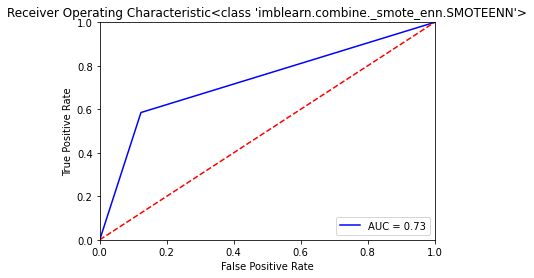

In [29]:
plotModel(tmp, tec)

In [30]:
tec = SMOTETomek
tmp, counter = trainPredict(tec)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9277,0.9691,0.9044,0.9485,0.9260,0.8553,0.8562
1,0.9245,0.9679,0.9050,0.9418,0.9230,0.8490,0.8497
2,0.9219,0.9705,0.9050,0.9368,0.9206,0.8438,0.8443
3,0.9250,0.9733,0.9081,0.9400,0.9238,0.8501,0.8506
4,0.9227,0.9721,0.9039,0.9392,0.9212,0.8454,0.8460
5,0.9219,0.9676,0.9102,0.9321,0.9210,0.8438,0.8440
6,0.9172,0.9648,0.8956,0.9361,0.9154,0.8344,0.8352
7,0.9308,0.9720,0.9133,0.9464,0.9296,0.8615,0.8621
8,0.9279,0.9662,0.9013,0.9520,0.9260,0.8558,0.8570
9,0.9206,0.9650,0.8981,0.9404,0.9188,0.8412,0.8420


Counter({1: 27347, 0: 27347})


[[8646  491]
 [ 708  452]]
0.3896551724137931


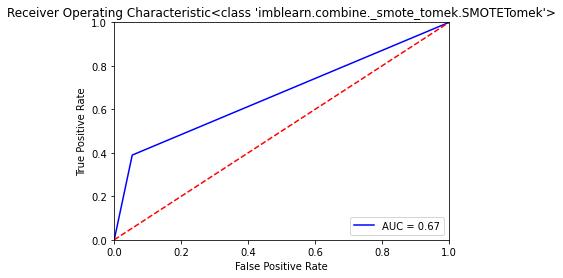

In [31]:
plotModel(tmp, tec)

### Results

##### No Sampling      
AUC: 0.62; 843/317; 0.27


##### SMOTE          
AUC: 0.66; 718/442; 0.38

##### ADASYN                                       
AUC: 0.67; 712/448; 0.39


##### RandomOverSampler                           
AUC: 0.73; 461/699; 0.6


##### KMeansSMOTE    
AUC: 0.63; 827/333; 0.28


##### SVMSMOTE   
AUC: 0.69; 665/495; 0.43


##### SMOTEENN                                   
AUC: 0.74; 457/703; 0.61


##### SMOTETomek                                     
AUC: 0.67; 718/442; 0.38



Based on the above results, it is clear that Random oversample has the best results among over sampling techniques whereas SMOTEENN is slightly better than random over sampling technique with slight improvement in AUC and recall scores

Iteration 2: Comparing performance of the above iteration with two major modifications.

1. Retaining duration column
2. Testing model performance without pycaret

In [32]:
X = df.drop(columns = ['y'], axis = 1)
y = df['y']
y.shape

(41188,)

In [33]:
y = y.replace('no', 0)
y = y.replace('yes', 1)
counter = Counter(y)
print(counter)

Counter({0: 36548, 1: 4640})


In [34]:
Xd = pd.get_dummies(X, drop_first = True)
Xd.shape

(41188, 53)

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xd, y, stratify=y, test_size=0.25)

In [36]:
#Training Logistic on actual dummy data

df_ori = pd.concat([X_train, y_train], axis = 1)
classification_setup = classification.setup(data= df_ori, target='y', fix_imbalance = False)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:35:32
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
age,Numeric
duration,Numeric
campaign,Numeric
pdays,Numeric
previous,Categorical
emp.var.rate,Numeric
cons.price.idx,Numeric
cons.conf.idx,Numeric
euribor3m,Numeric
nr.employed,Numeric


KeyboardInterrupt: Interrupted by user

In [ ]:
lgbms = create_model('lightgbm', learning_rate = 0.3)

In [ ]:
tec = ' - With Duration Column'
plotModel(lgbms, tec)

In [ ]:
Xd = df.drop(columns = ['y'], axis = 1)
y = df['y']
y.shape

In [ ]:
y = y.replace('no', 0)
y = y.replace('yes', 1)
counter = Counter(y)
print(counter)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xd, y, stratify=y, test_size=0.25)

In [ ]:
#Training Logistic on actual dummy data

df_ori = pd.concat([X_train, y_train], axis = 1)
classification_setup = classification.setup(data= df_ori, target='y', fix_imbalance = False)

In [ ]:
lgbms = create_model('lightgbm', learning_rate = 0.3)

In [ ]:
tec = ' - With Duration Column + No Dummies'
plotModel(lgbms, tec)

The above results are summarised as follows.

1. There is a huge increase in AUC as well as recall when duration column is added for model training. i.e. 0.76 against 0.62
2. Creating dummies increases the AUC and recall slightly.

Thus this experiment concludes the following points:
1. Though the duration column is suggested to be removed during model training, adding the column increases the prediction performance significantly. 
2. All the reviewed papers use duration column and thus achieve have a highly boosted score.Those values cannot be translated to real time prediction setup
3. SMOTEENN and RandomOverSampler are the top contenders for final research implementation and both of them could be considered as the difference is very minute between their results.